In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd
from scipy.stats import multivariate_normal
import csv
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from pylab import cm
from datetime import datetime, timedelta

from scipy.signal import find_peaks, find_peaks_cwt

import sys
sys.path.append('../Code')
from plotting import set_rcParams
set_rcParams()

#from IPython.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# find largest number smaller then, and smallest number larger then, 'value' inside a sorted 'array' as well the corresponding interpolation factor
def find_window(value, array):
    for i,v in enumerate(array):
        if v >= value:
            # return window
            if i>0: return array[i-1], v, (value-array[i-1])/(v-array[i-1])
            # if value is smaller than any of array, get interpolation factor from linear extrapolation from the smallest two values in array
            else: return v, array[1], (value-v)/(array[1]-v)
    
    # if value is larger than any of array, get interpolation factor from linear extrapolation from the largest two values in array
    return array[-2], array[-1], (value-array[-2])/(array[-1]-array[-2])

# compute time-resolved incidence with time-resolved population data
population_data = pd.read_csv('../data/real_data/population-by-country.csv', header=0, sep=',')
population_data['Total population (Fink-Jensen 2015)'] *=1000
def abs_to_incidence(row):
    population = population_data.loc[population_data['Entity']==row['country']]
    lower, upper, t = find_window(row['date'].year, population['Year'].values)
    lower_population = population.loc[population['Year']==lower]['Total population (Fink-Jensen 2015)'].values[0]
    upper_population = population.loc[population['Year']==upper]['Total population (Fink-Jensen 2015)'].values[0]
    incidence = row['numValue'] / (lower_population*(1-t) + upper_population*t)
    return pd.Series([incidence], index=['incidence'])

In [3]:
# find the peaks in a given noisy dataset; builds on scipy's find_peaks_cwt function
def find_maxima(timeseries, widths=[5,6], half_peak_width=3, min_snr=10, edge_tolerance=3, two_peak_distance=4):
    # find rough peaks with find_peaks_cwt
    peak_indices = find_peaks_cwt(timeseries, widths=widths)
    
    # Get peak heights + slightly correct some errors of the algorithm
    peak_indices_corrected = []
    peak_heights = []
    last = -two_peak_distance-1
    for i,peak in enumerate(peak_indices):
        # correct position closer to actual maximum
        corrected_peak = timeseries[max(peak-half_peak_width,0):min(peak+half_peak_width,len(timeseries))].argmax()-half_peak_width+peak

        # throw out peaks too close to the edges or too close to the previous peak
        if (corrected_peak >= edge_tolerance) and (corrected_peak <= len(timeseries)-edge_tolerance) and ((corrected_peak-last)>two_peak_distance):
            last = corrected_peak
            peak_indices_corrected.append(corrected_peak)
            peak_heights.append(timeseries[corrected_peak])
    peak_indices_corrected = np.array(peak_indices_corrected)
    peak_heights = np.array(peak_heights)

    # return incides and heights of the peaks
    return peak_indices_corrected, peak_heights

# ECDC Influenza

##### Timeseries

In [181]:
### Data loading and processing
# Read in data
data = pd.read_csv('../data/real_data/ecdc_influenza.csv', header=0, sep=',', usecols=['RegionName','Time', 'NumValue'])
data = data.rename(columns={"RegionName":"country"})
data = data.rename(columns={"Time":"date"})
data = data.rename(columns={"NumValue":"numValue"})

# fix date
data['date'] = pd.to_datetime(data['date']+'-1', format='%Y-W%W-%w')

# exclude EU and small countries with little data
exclude=['Iceland', 'Malta', 'Croatia', 'Cyprus', 'EU/EEA', 'Luxembourg']
for ex in exclude:
    data = data.loc[data['country'] != ex]

# exlude alld data before week 40 of year 2019
start, end = ('2010-01-01','2019-09-30')
data = data.loc[(data['date']<=end) & (data['date']>=start)]

# calculate incidence relative to pulation size 
data['incidence'] = data.apply(abs_to_incidence, axis=1)['incidence']
data['incidence'] *= 1e6 # per million

# print out countries that are left in the dataset
print(data['country'].unique())

# delete unneeded column
data = data.drop('numValue', axis=1)

# print to file
data.to_csv('../data/processed/ECDC_influenza_timeseries.csv', index=False)

['Austria' 'Belgium' 'Bulgaria' 'Czechia' 'Germany' 'Denmark' 'Estonia'
 'Greece' 'Spain' 'France' 'Hungary' 'Ireland' 'Lithuania' 'Latvia'
 'Netherlands' 'Norway' 'Poland' 'Portugal' 'Romania' 'Sweden' 'Slovenia'
 'Slovakia' 'Italy' 'Finland']


##### Peaks

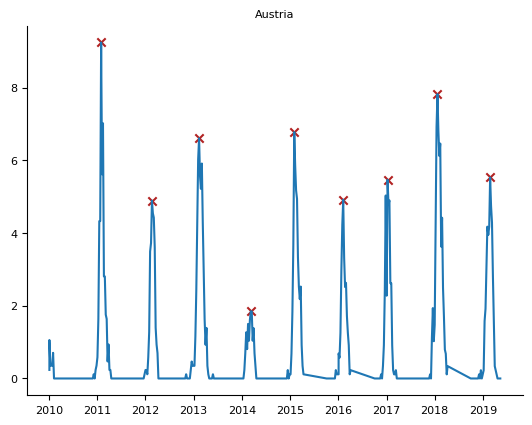

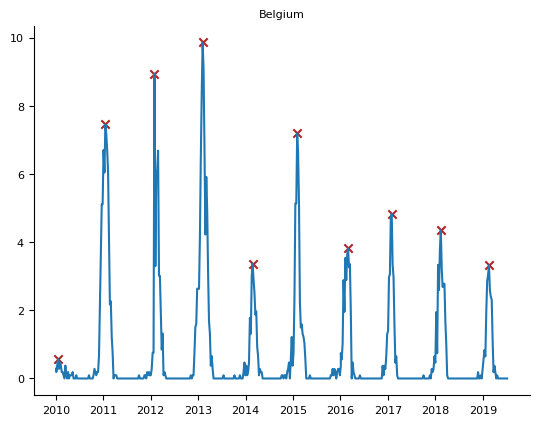

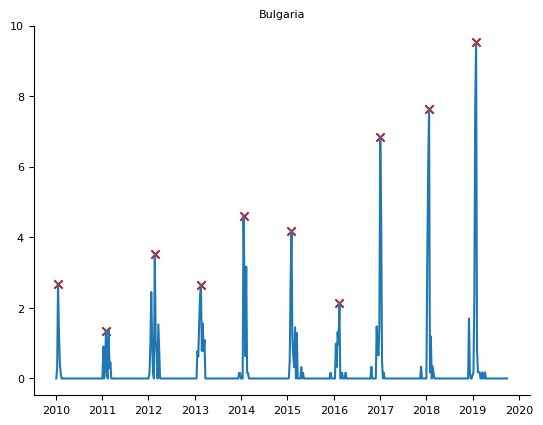

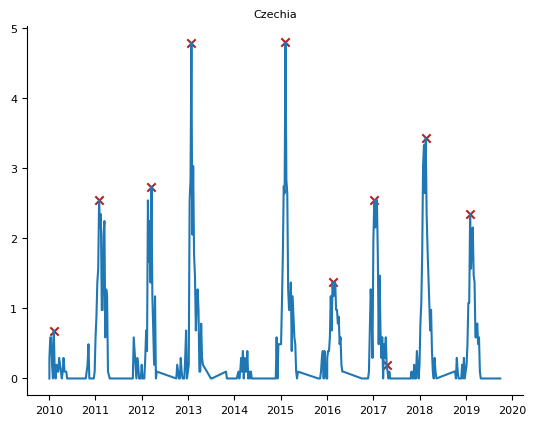

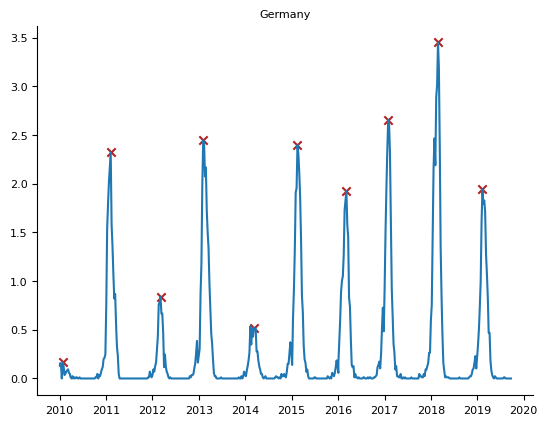

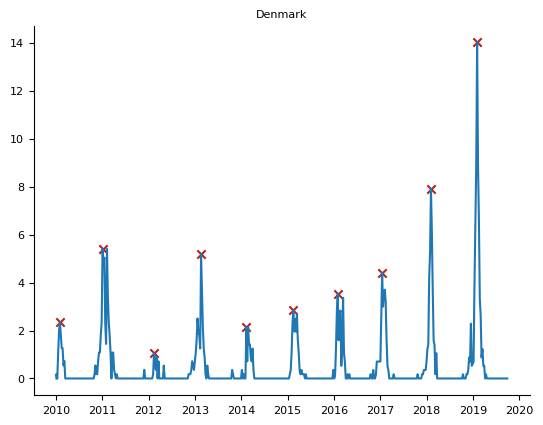

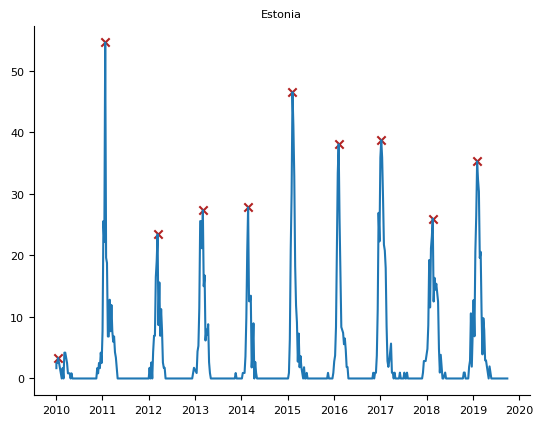

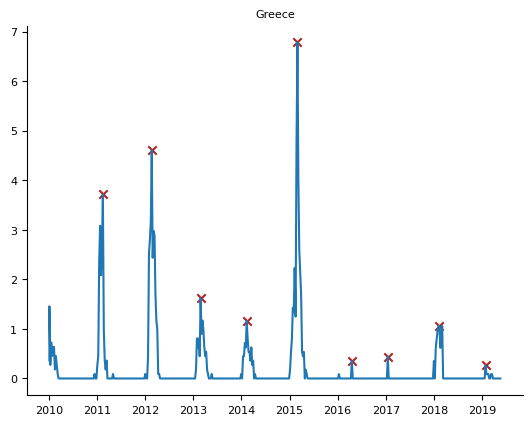

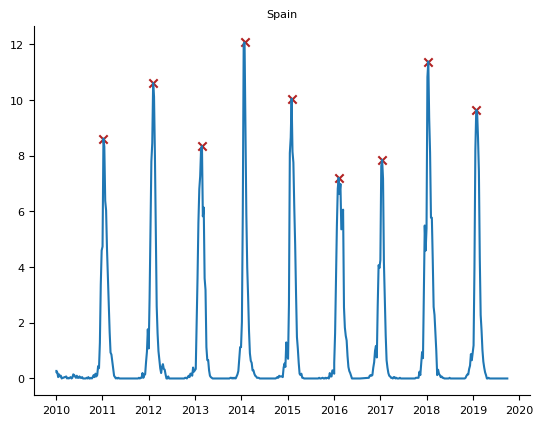

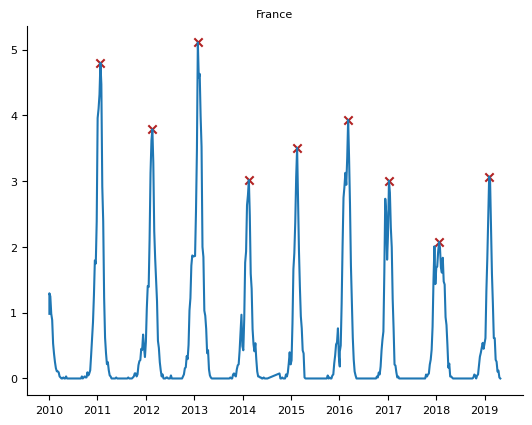

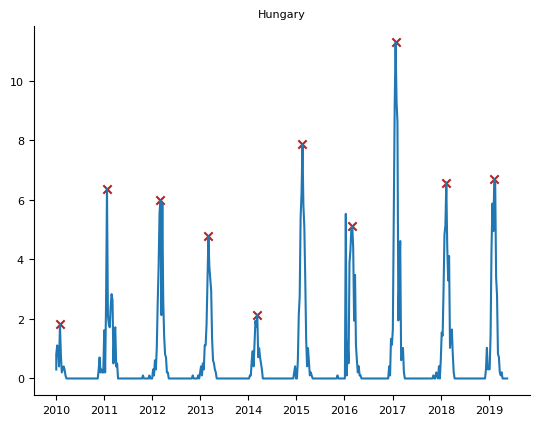

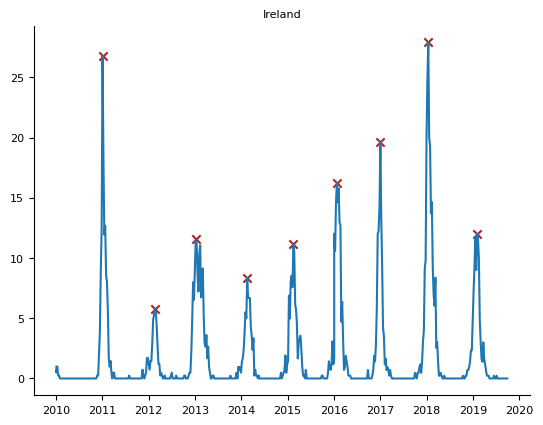

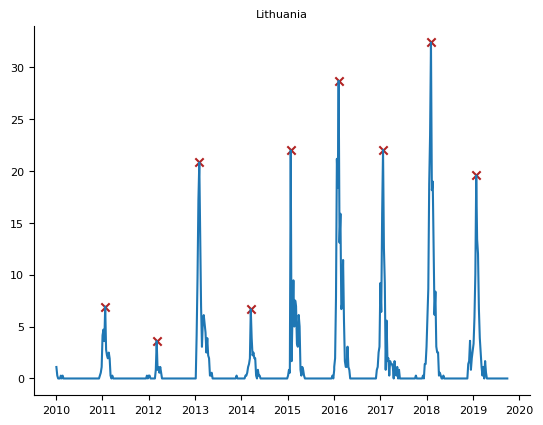

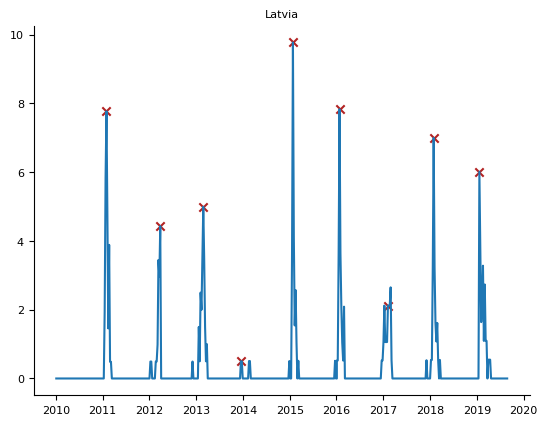

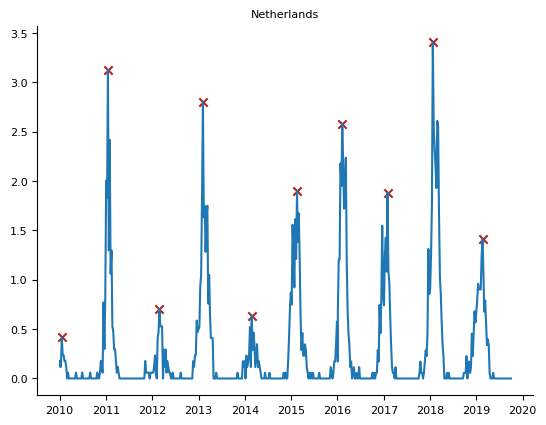

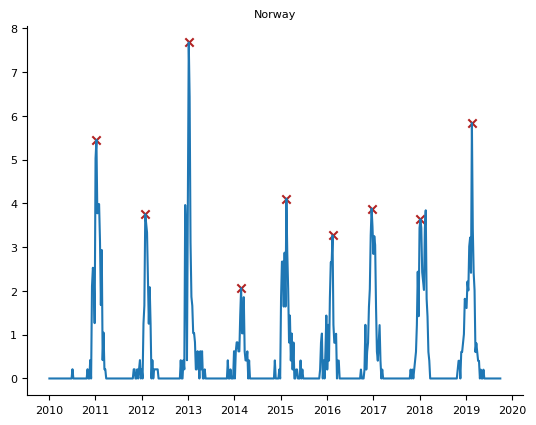

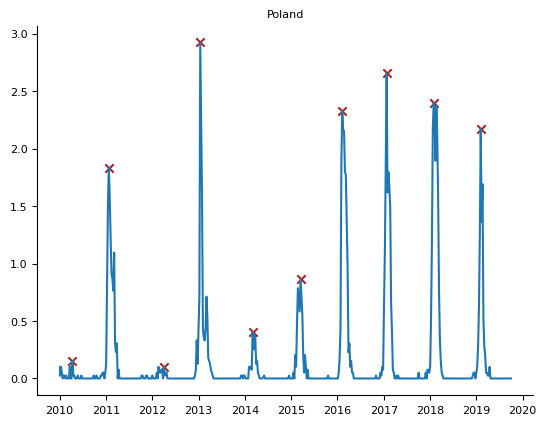

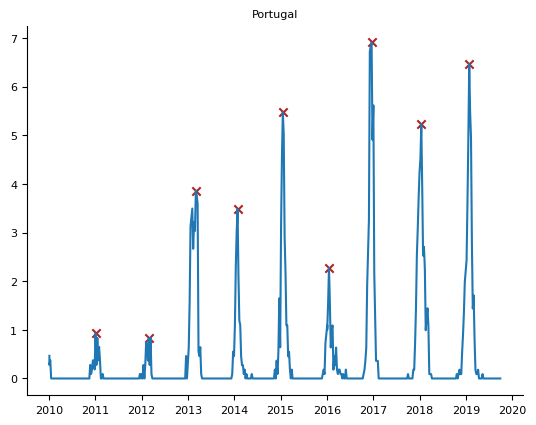

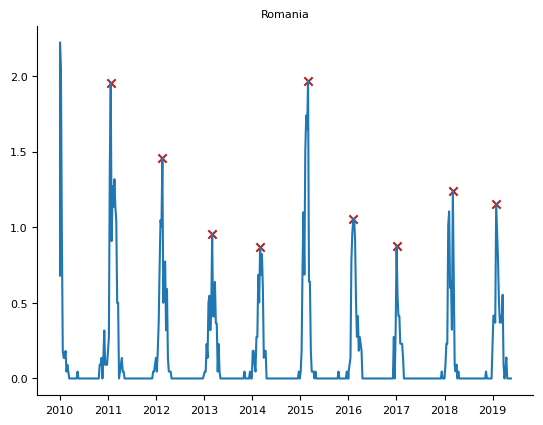

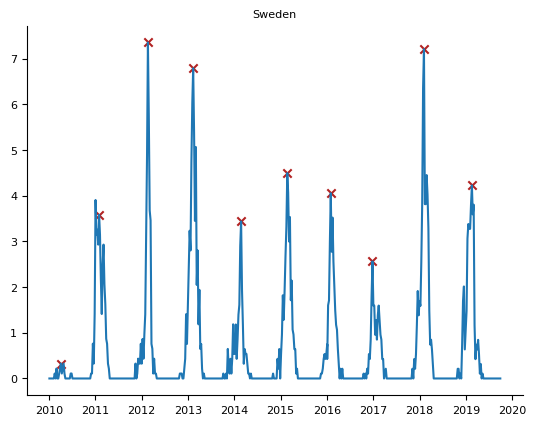

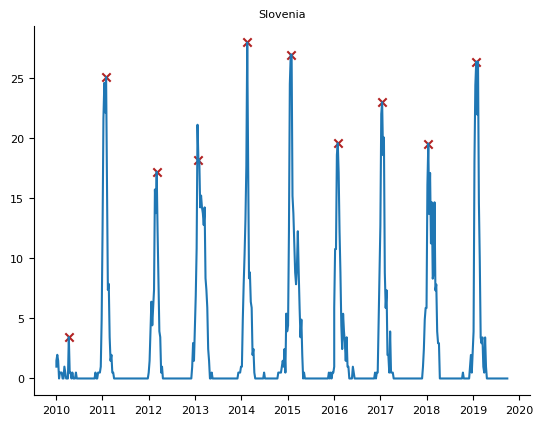

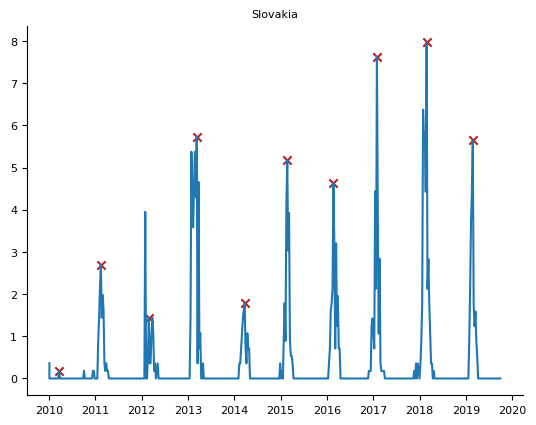

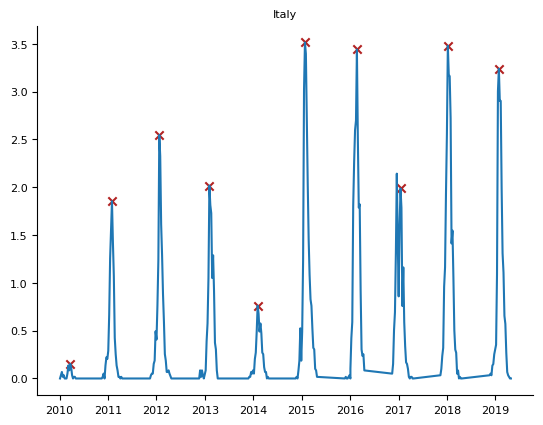

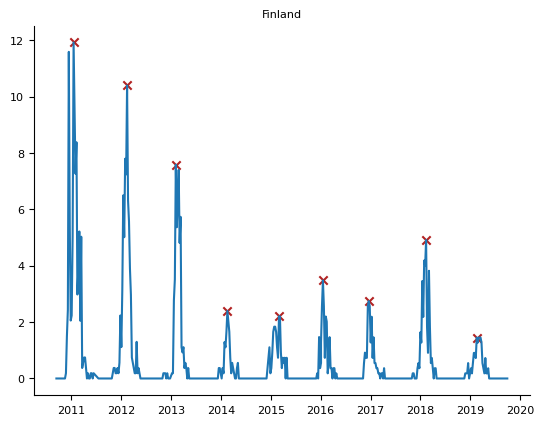

In [182]:
%matplotlib inline

# True makes a single plot for each country, False plots all of them in one plot
show_individual = True

# numpy arrays collecting the data for all peaks in all countries; later to be converted into pandas dataframe
countries_all = []
peak_heights_all = []
dates_all = []
peak_distances_all = []

for country in data['country'].unique():
    # retrieve data for this country and plot incidence
    timeseries = data.loc[data['country']==country].reset_index()
    plt.plot(timeseries['date'], timeseries['incidence'])

    # find the peaks
    peak_indices, peak_heights = find_maxima(timeseries['incidence'].values, half_peak_width=3, two_peak_distance=10)

    # save the peak data
    countries_all.extend([country]*len(peak_indices))   # country name
    peak_heights_all.extend(peak_heights)               # peak height (incidence)
    dates = timeseries['date'].iloc[peak_indices]       # peak timing
    dates_all.extend(dates)
    peak_distances_all.extend((dates-np.roll(dates,1)).dt.days/7)    # time between consecutive peaks; end points lead to negative T here, filter out later

    # plot the peaks
    plt.scatter(dates, peak_heights, marker='x', color='firebrick')

    if show_individual:
        plt.title(country)
        plt.show()

if not show_individual:
    plt.show()

# convert numpy arrays to pandas dataframe
peaks = pd.DataFrame({'country':countries_all, 'date':dates_all, 'incidence':peak_heights_all, 'T':peak_distances_all})

# remove negative time between peaks; artifact of using "roll" to calculate them above
peaks.loc[peaks['T']<0,'T'] = np.NaN

# output pandas peak dataframe to 
peaks.to_csv('../data/processed/ECDC_influenza_peaks.csv', index=False)

# OWID COVID-19

##### Timeseries

In [16]:
### Data loading and processing
# Read in data and rename columns
data = pd.read_csv('../data/real_data/owid-covid-data.csv', header=0, sep=',', usecols=['location','date', 'new_cases_smoothed_per_million'], parse_dates=['date'])
data = data.rename(columns={"location":"country"})
data = data.rename(columns={"new_cases_smoothed_per_million":"incidence"})

# restrict to certain countries
countries = ['Italy', 'Spain', 'Portugal', 'Israel', 'Germany', 'France', 'United States', 'Canada', 'Switzerland', 'Austria', 'Netherlands', 'Belgium', 'Poland', 'Czechia', 'Croatia', 'Denmark', 'Sweden', 'Lithuania']
data = data[data['country'].isin(countries)].reset_index(drop=True)

# restrict to certain timeframe
start, end = ('2020-07-01','2022-10-31') # all
#start, end = ('2020-07-01','2021-10-20') # before Omicron
#start, end = ('2021-10-20','2022-10-31') # after Omicron
data = data.loc[(data['date']<=end) & (data['date']>=start)]

# print to file
data.to_csv('../data/processed/OWID_covid19_timeseries_allOmicron.csv', index=False)

##### Peaks

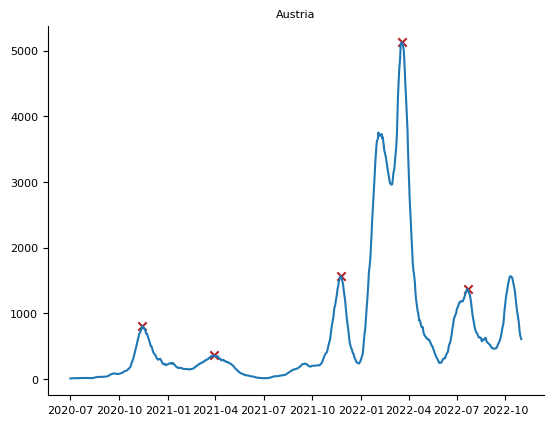

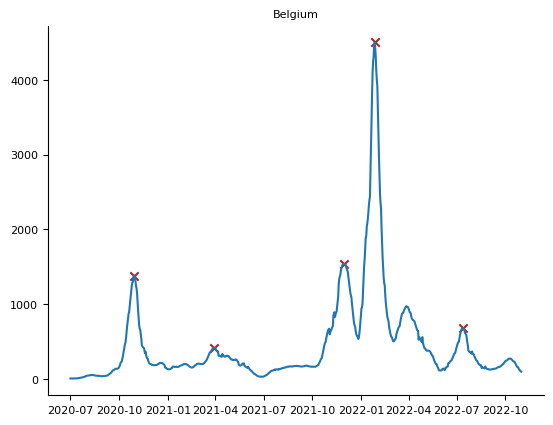

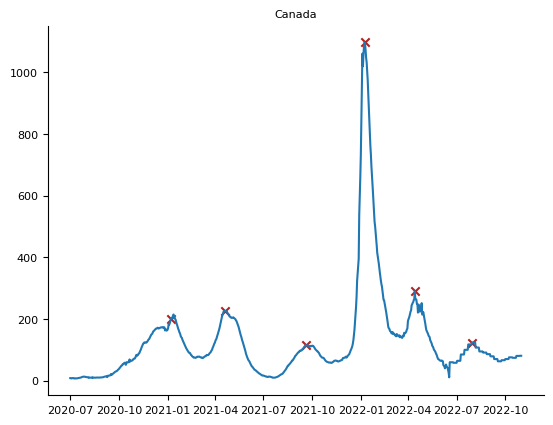

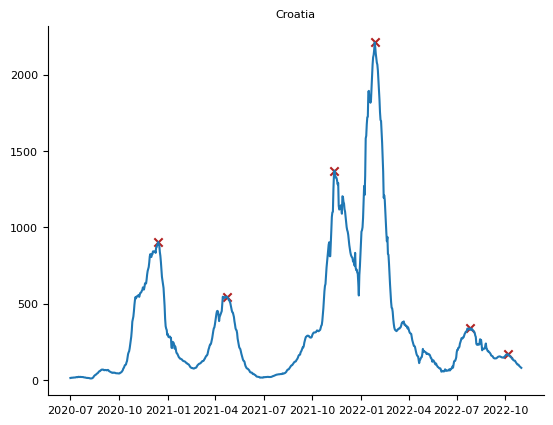

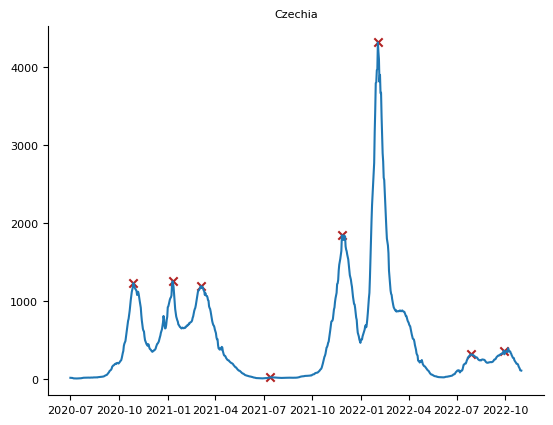

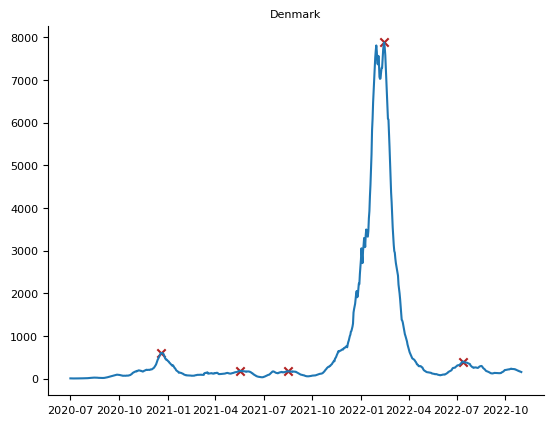

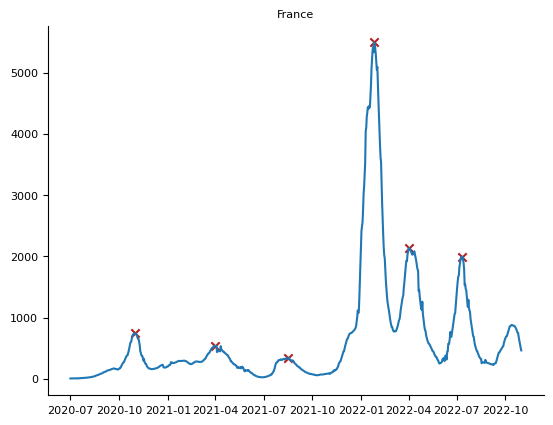

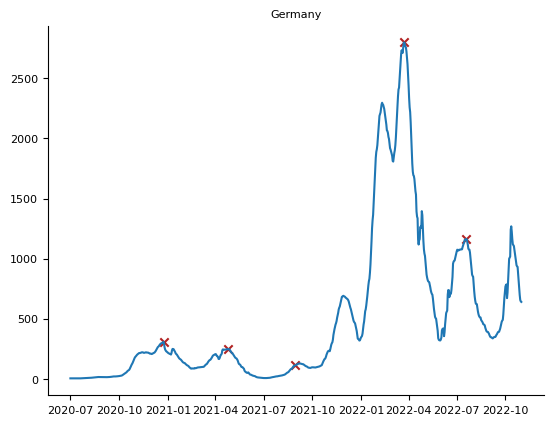

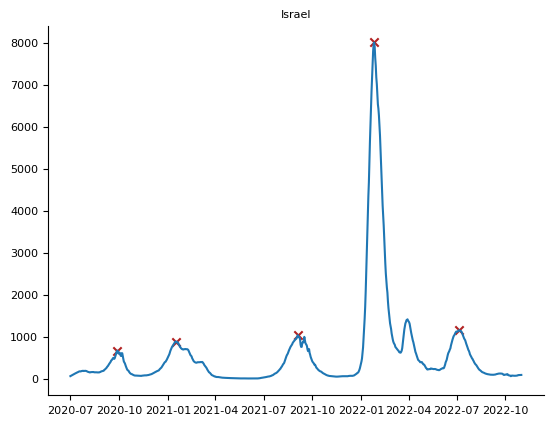

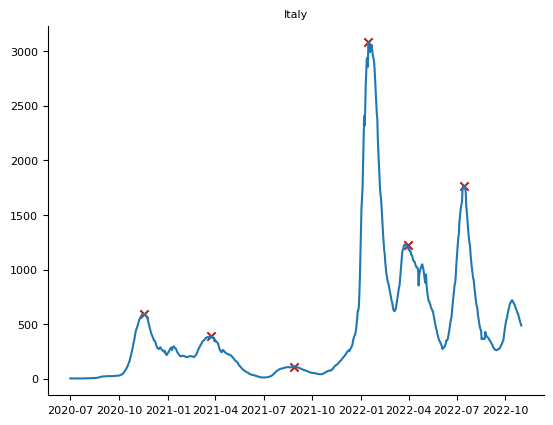

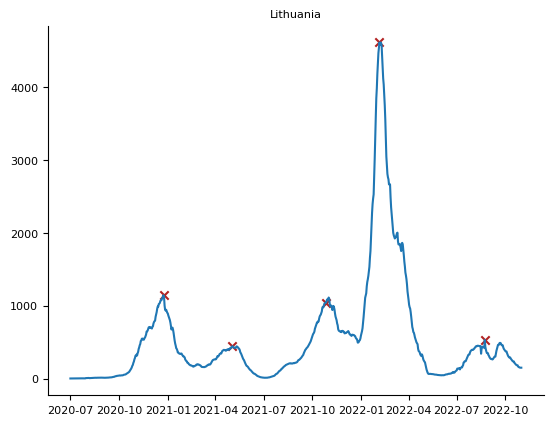

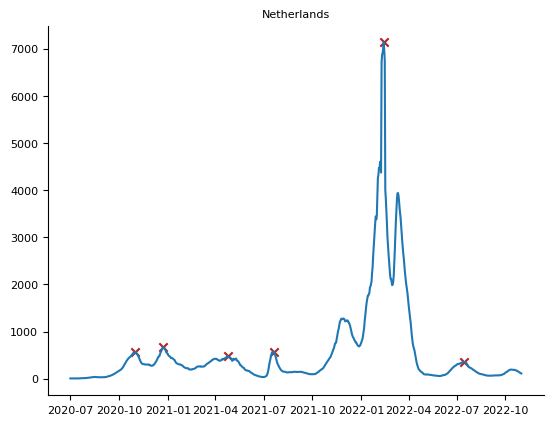

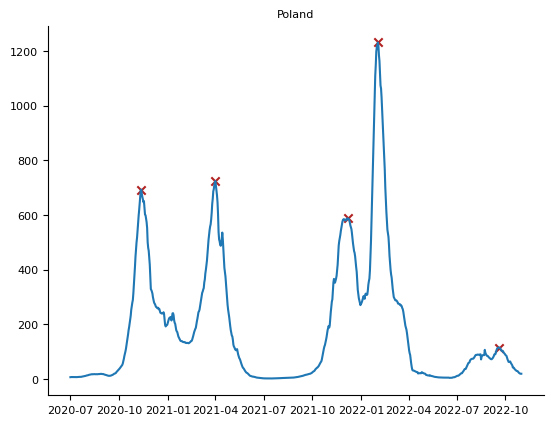

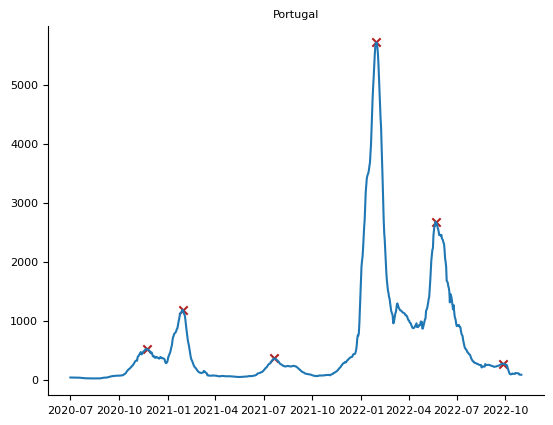

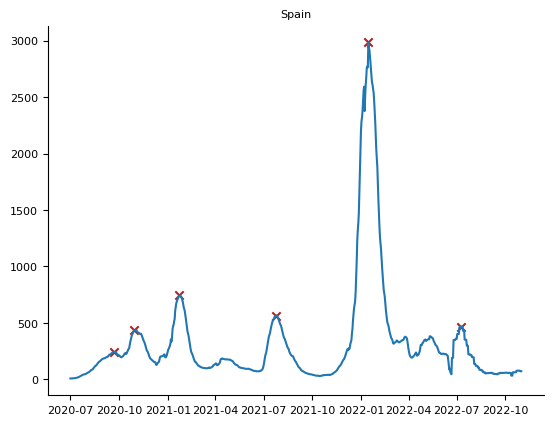

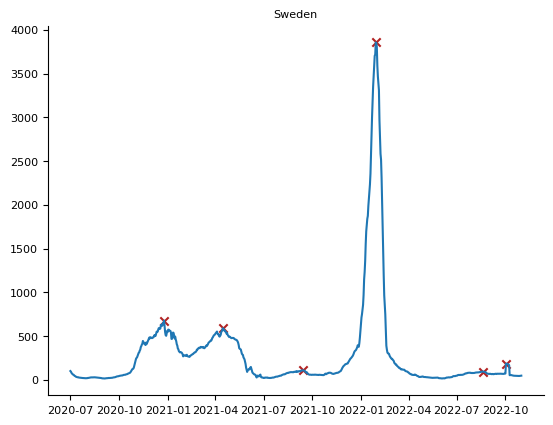

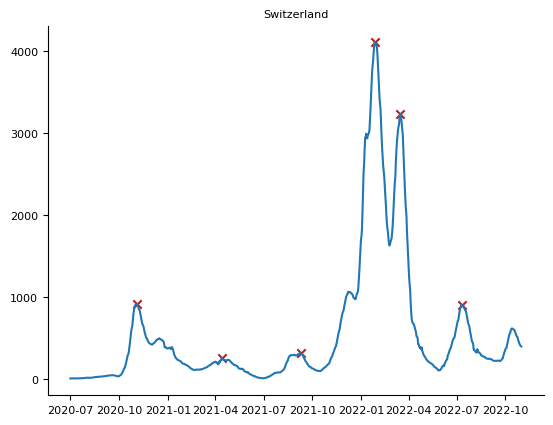

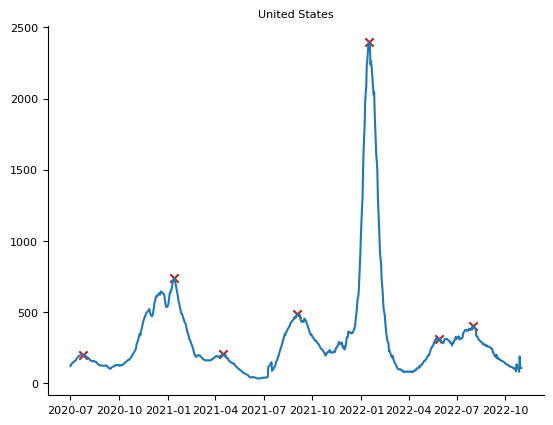

In [17]:
%matplotlib inline

#manual_peaks = pd.read_csv('../data/real_data/distributions_measured.csv', header=0, sep=',', usecols=['country','ik', 'tk'], parse_dates=['tk'])


# True makes a single plot for each country, False plots all of them in one plot
show_individual = True

# numpy arrays collecting the data for all peaks in all countries; later to be converted into pandas dataframe
countries_all = []
peak_heights_all = []
dates_all = []
peak_distances_all = []

for country in data['country'].unique():
    # retrieve data for this country and plot incidence
    timeseries = data.loc[data['country']==country].reset_index()
    plt.plot(timeseries['date'], timeseries['incidence'])

    # find the peaks
    peak_indices, peak_heights = find_maxima(timeseries['incidence'].values, widths=[25,40], half_peak_width=20, edge_tolerance=24, two_peak_distance=30)

    # save the peak data
    countries_all.extend([country]*len(peak_indices))   # country name
    peak_heights_all.extend(peak_heights)               # peak height (incidence)
    dates = timeseries['date'].iloc[peak_indices]       # peak timing
    dates_all.extend(dates)
    peak_distances_all.extend((dates-np.roll(dates,1)).dt.days/7)    # time in weeks between consecutive peaks; end points lead to negative T here, filter out later

    #manual = manual_peaks.loc[manual_peaks['country']==country].reset_index()
    # plot the peaks
    plt.scatter(dates, peak_heights, marker='x', color='firebrick')
    #plt.scatter(manual['tk'], manual['ik'], marker='x', color='orange')

    if show_individual:
        plt.title(country)
        plt.show()

if not show_individual:
    plt.show()

# convert numpy arrays to pandas dataframe
peaks = pd.DataFrame({'country':countries_all, 'date':dates_all, 'incidence':peak_heights_all, 'T':peak_distances_all})

# manually remove last peak in Belgium data
peaks = peaks[(peaks['country']!='Belgium') | (peaks['date']<datetime.strptime("2021-07-01", "%Y-%m-%d"))]

# remove negative time between peaks; artifact of using "roll" to calculate them above
peaks.loc[peaks['T']<0,'T'] = np.NaN

# output pandas peak dataframe to 
peaks.to_csv('../data/processed/OWID_covid19_peaks_allOmicron.csv', index=False)